In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [2]:
results = pd.read_csv("test_results/pg_optimisations_retry_tpch_queries_test_results.csv") 
test_name = "postgres_optimisations"

results = results.rename(columns={"Average": "Mean"})

In [3]:
#print(len(results))
#results.head()

In [4]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

154


In [5]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)
    
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def ignore_first_mean_geom(runs):
    return g_mean(runs[1:])

results['Mean'] = results.apply(lambda row : ignore_first_mean_geom(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

In [6]:
def process_optim_type(name):
    split_name = name.split(" ")
    if split_name[-1] == "Baseline":
        return "B"
    else:
        return str(split_name[-1]).strip()

results = results[results["Data Type"] != "SQL"]
results['Optimisation'] = results.apply(lambda row : process_optim_type(row['Query Name']), axis = 1)

In [7]:
results = results.sort_values(by=['Query Number', 'Query Name'], ascending=[True, True])

In [8]:
#results
unique_query_numbers = list(results["Query Number"].unique())
q_scores_in_order = []
#unique_query_numbers
for q_num in unique_query_numbers:
    baseline_score = float(results[(results["Query Number"] == q_num) & (results["Optimisation"] == "B")]["Mean"])
    query_scores = results[(results["Query Number"] == q_num) & (results["Optimisation"] != "B")]
    
    optimisation_types = list(query_scores["Optimisation"].unique())
    for optim in optimisation_types:
        current_q_score = query_scores[query_scores["Optimisation"] == optim]
        q_scores_in_order.append(float((baseline_score - current_q_score["Mean"]) / baseline_score))
    q_scores_in_order.append(0)
    
    #print(baseline_score)

In [9]:
results['Optim_improve'] = pd.Series(q_scores_in_order, index=results.index)

In [10]:
optim_results = results \
    .groupby(by=["Optimisation"]) \
    .agg(
            avg_percent_improve=("Optim_improve", "mean"),
        )

optim_results['Percentage Improvement'] = optim_results['avg_percent_improve'].apply(lambda x: x*100)
optim_results = optim_results.reset_index()
optim_results = optim_results[optim_results["Optimisation"] != "B"]
optim_results = optim_results[["Optimisation", "Percentage Improvement"]]
print(optim_results.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Optimisation &  Percentage Improvement \\
\midrule
           1 &               -0.017079 \\
       1+2+3 &                0.550513 \\
           2 &                0.128606 \\
         2+3 &                0.377529 \\
           3 &                0.028307 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_17885/942183370.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(optim_results.to_latex(index=False))


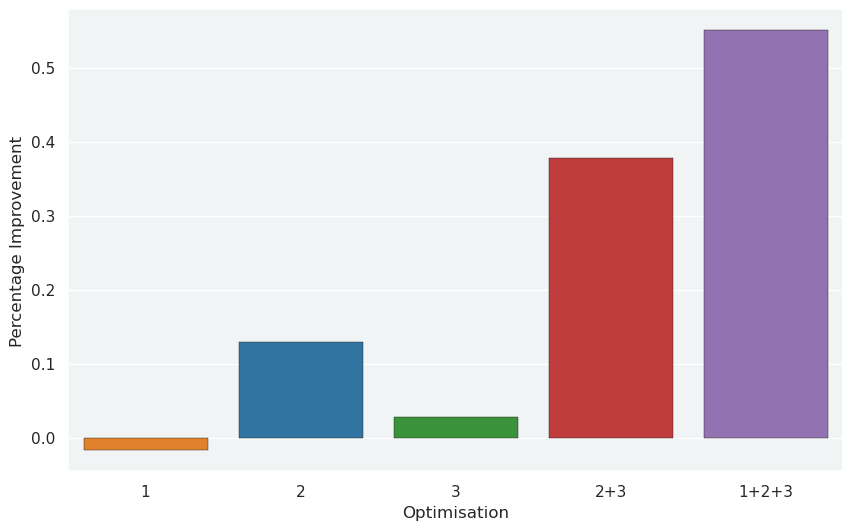

In [11]:
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

colors = ['tab:orange','tab:blue','tab:green', 'tab:red', 'tab:purple']
optim_order = ["1", "2", "3", "2+3", "1+2+3"]

ax = sns.barplot(data=optim_results, x='Optimisation', y='Percentage Improvement',
                 order=optim_order, palette=colors)

plt.savefig("analysis_results/" + str(test_name) + "_compare.pdf", bbox_inches="tight")
plt.show()

In [12]:
sort_res = results.sort_values(by=["Optim_improve"], ascending=False)
sort_res[sort_res["Query Number"] == 13]

,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs,Query Type,Optimisation,Optim_improve
85,Pandas,1,Pandas Baseline,13,1.996691,True,Yes,"[2.211064338684082, 1.981858730316162, 2.01536...",Pandas Baseline,B,0.000000
87,Pandas,1,Pandas 2,13,2.011116,True,Yes,"[2.0847365856170654, 2.0121281147003174, 2.024...",Pandas 2,2,-0.007224
88,Pandas,1,Pandas 3,13,2.018594,True,Yes,"[2.1278209686279297, 2.0304818153381348, 2.013...",Pandas 3,3,-0.010970
86,Pandas,1,Pandas 1,13,2.020074,True,Yes,"[2.138037919998169, 1.9940385818481445, 1.9893...",Pandas 1,1,-0.011711
89,Pandas,1,Pandas 2+3,13,2.025371,True,Yes,"[2.1352365016937256, 2.024132251739502, 2.0649...",Pandas 2+3,2+3,-0.014364
90,Pandas,1,Pandas 1+2+3,13,2.104574,True,Yes,"[2.0856688022613525, 2.0210752487182617, 2.120...",Pandas 1+2+3,1+2+3,-0.054031


### Make a graph for Q5, Q13 and Q22

In [13]:
specific_queries = results[(results["Query Number"].isin([5,13,22])) & (results["Optimisation"].isin(["B", "1+2+3"]))]
#specific_queries.head(20)

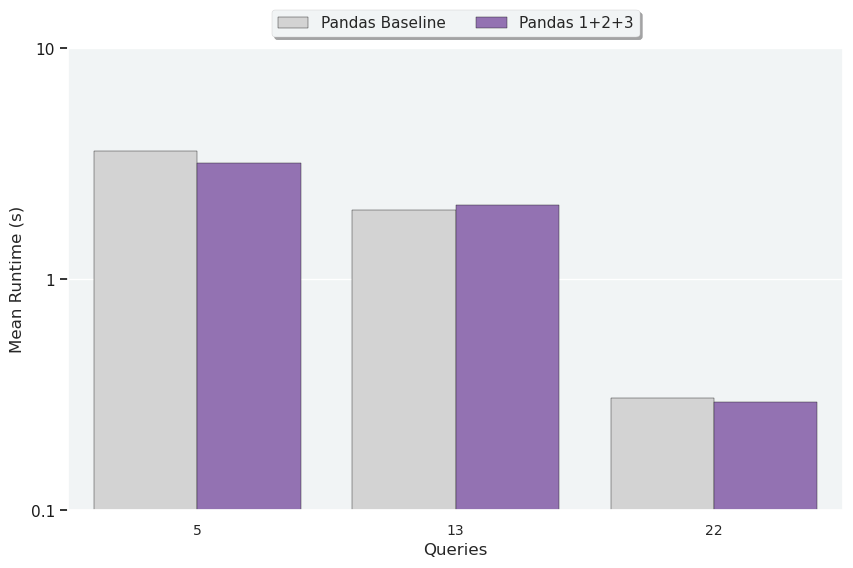

In [14]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

# The other colors are 70% tints of the original
# From: https://imagecolorpicker.com/color-code/
color = ['lightgrey','tab:purple']
order = ["Pandas Baseline", "Pandas 1+2+3"]

ax = sns.barplot(data=specific_queries, x='Query Number', y='Mean', hue='Query Type',
                 palette=color, hue_order=order)

ax.set_yscale("log")
ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

# the non-logarithmic labels 
ticks = [0.1, 1, 10]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=4, fancybox=True, shadow=True)

plt.savefig("analysis_results/" + str(test_name) + "_specific_queries.pdf", bbox_inches="tight")
plt.show()